In [2]:
EPOCHS = 300
BATCH_SIZE = 128
MIN_LEARNING_RATE = 1e-15

## Installing Libraries

In [3]:
# !pip install pubchempy --quiet
!pip install rdkit-pypi --quiet
!pip install openpyxl --quiet
!pip install pydot graphviz --quiet

In [4]:
import pandas as pd
# import pubchempy as pcp
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import random
import openpyxl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error)
import math
import scipy.stats as stats

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Concatenate, Conv2D, Dense, Flatten, Input, MaxPooling2D)
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model, Sequence

# from tqdm.auto import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

## Setting up TPU/GPU

In [5]:
# Detect if GPU is available and configure TensorFlow to use it
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected.")

# If TPU is available, you can use it as follows:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
    tpu_ = 1
except ValueError:
    strategy = tf.distribute.MirroredStrategy()  # Use GPU or CPU strategy
    print("Running on CPU")

No GPU detected.
Running on TPU


## Functions

In [6]:
def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed * 2 / res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims, dims, 4))

    # Bonds first
    for bond in mol.GetBonds():
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0, 1, int(1 / res * 2))
        for f in frac:
            c = (f * bcoords + (1 - f) * ecoords)
            idx = int(np.clip(round((c[0] + embed) / res), 0, dims - 1))
            idy = int(np.clip(round((c[1] + embed) / res), 0, dims - 1))
            vect[idx, idy, 0] = bondorder

    # Atom Layers
    for i, atom in enumerate(cmol.GetAtoms()):
        idx = int(np.clip(round((coords[i][0] + embed) / res), 0, dims - 1))
        idy = int(np.clip(round((coords[i][1] + embed) / res), 0, dims - 1))
        # Atomic number
        vect[idx, idy, 1] = atom.GetAtomicNum()
        # Gasteiger Charges
        charge = atom.GetProp("_GasteigerCharge")
        vect[idx, idy, 3] = charge
        # Hybridization
        hyptype = atom.GetHybridization().real
        vect[idx, idy, 2] = hyptype

    return vect

In [7]:
def add_smiles_codes(df, column_name='DRUG_NAME'):
    # Check if the specified column name exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    # Function to get SMILES code using pubchempy
    def get_smiles(drug_name):
        try:
            compounds = pcp.get_compounds(drug_name, 'name')
            return compounds[0].isomeric_smiles if compounds else None
        except:
            return None

    # Apply the get_smiles function to each drug name in the specified column
    df['SMILES'] = df[column_name].progress_apply(get_smiles)

    return df

In [8]:
# Custom data generator to handle images and additional features
class DataGenerator(Sequence):
    def __init__(self, images, features, labels, batch_size, augmentor=None):
        self.images = images
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_start = index * self.batch_size
        batch_end = (index + 1) * self.batch_size
        batch_images = self.images[batch_start:batch_end]
        batch_features = self.features[batch_start:batch_end]
        batch_labels = self.labels[batch_start:batch_end]

        if self.augmentor:
            augmented_images = np.array([self.augmentor.random_transform(img) for img in batch_images])
        else:
            augmented_images = batch_images

        return [augmented_images, batch_features], batch_labels

In [9]:
def coeff_determination(y_true, y_pred):
    y_true = K.cast(y_true, 'float64')
    y_pred = K.cast(y_pred, 'float64')
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

In [10]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.learning_rate
    return lr

In [11]:
# Helper functions
def Inception0(input):
    tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

    tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)

    output = Concatenate()([tower_1, tower_2, tower_3])
    return output

def Inception(input):
    tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
    tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

    output = Concatenate()([tower_1, tower_2, tower_3])
    return output

## Data Manipulation

In [12]:
data1 = (pd
        .read_excel(
            'https://cog.sanger.ac.uk/cancerrxgene/GDSC_release8.5/GDSC2_fitted_dose_response_27Oct23.xlsx',
            usecols = ['CELL_LINE_NAME', 'DRUG_NAME', 'MIN_CONC', 'MAX_CONC', 'LN_IC50'])
        .drop_duplicates())
data1.sample(10)

,CELL_LINE_NAME,DRUG_NAME,MIN_CONC,MAX_CONC,LN_IC50
169392,42-MG-BA,BEN,0.030016,30.0,2.776826
197367,NCI-H2170,Savolitinib,0.001001,1.0,2.011353
54038,CAL-29,BI-2536,0.001001,1.0,-3.142946
95922,NCI-H2731,Taselisib,0.004002,10.0,1.918090
160953,A375,L-Oxonoreleagnine,0.003002,3.0,4.686880
69972,GA-10,Fulvestrant,0.001001,1.0,2.474666
239913,HCC1937,glutathione,0.640337,640.0,10.213379
78253,RERF-LC-KJ,Dabrafenib,0.010005,10.0,5.463470
99938,NCI-H345,GSK2801,0.010005,10.0,6.727296
215697,COR-L32,Ulixertinib,0.002001,2.0,3.533054


In [13]:
# data2 = data1[['DRUG_NAME']].drop_duplicates()
# data2 = add_smiles_codes(data2)
data2 = pd.read_csv('/content/data_SMILES_v2.csv')
print(data2.shape)

(286, 2)


In [14]:
print(data2[data2.SMILES.isnull()].shape)
data2[data2.SMILES.isnull()].sample(10)

(31, 2)


,DRUG_NAME,SMILES
123,BDILV000379a,NaN
154,PAK_5339,NaN
147,CDK9_5038,NaN
149,ERK_2440,NaN
168,LMB_AB3,NaN
240,N27922-53-1,NaN
121,BDOCA000347a,NaN
238,BPD-00008900,NaN
157,VSP34_8731,NaN
95,IAP_5620,NaN


In [15]:
data2 = data2[~data2.SMILES.isnull()]
print(data2.shape)
data2.sample(10)

(255, 2)


,DRUG_NAME,SMILES
19,GW441756,CN1C=C(C2=CC=CC=C21)/C=C\3/C4=C(C=CC=N4)NC3=O
114,SCH772984,C1CN(C[C@@H]1C(=O)NC2=CC3=C(C=C2)NN=C3C4=CC=NC...
227,I-BRD9,CCN1C=C(C2=C(C1=O)C=C(S2)C(=NC3CCS(=O)(=O)CC3)...
235,Sepantronium bromide,CC1=[N+](C2=C(N1CCOC)C(=O)C3=CC=CC=C3C2=O)CC4=...
162,GSK2110183B,CN1C(=C(C=N1)Cl)C2=C(SC(=C2)C(=O)N[C@@H](CC3=C...
102,Linsitinib,CC1(CC(C1)C2=NC(=C3N2C=CN=C3N)C4=CC5=C(C=C4)C=...
189,667880,C[C@H]1CCC2=C(C1)SC(=C2C#N)NC(=O)C=CC3=CC=CO3
119,SGC-CBP30,CC1=C(C(=NO1)C)C2=CC3=C(C=C2)N(C(=N3)CCC4=CC(=...
29,PLX-4720,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...
160,GSK2256098C,CC1=NN(C(=C1)NC2=NC=C(C(=C2)NC3=CC=CC=C3C(=O)N...


In [16]:
data2.loc[:, "mol"] = data2["SMILES"].progress_apply(Chem.MolFromSmiles)
data2.loc[:, "molimage"] = data2["mol"].progress_apply(chemcepterize_mol)

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

In [17]:
data2['molimage_min'] = data2['molimage'].apply(lambda x: np.min(x))
data2['molimage_mean'] = data2['molimage'].apply(lambda x: np.mean(x))
data2['molimage_max'] = data2['molimage'].apply(lambda x: np.max(x))

list_of_items = list(set((
    list(data2[data2.molimage_mean.isnull()].DRUG_NAME) +
    list(data2[data2.molimage_min.isnull()].DRUG_NAME) +
    list(data2[data2.molimage_max.isnull()].DRUG_NAME))))

print(list_of_items)
data2[data2['DRUG_NAME'].isin(list_of_items)]

['123829', 'Cisplatin']


,DRUG_NAME,SMILES,mol,molimage,molimage_min,molimage_mean,molimage_max
2,Cisplatin,N.N.Cl[Pt]Cl,<rdkit.Chem.rdchem.Mol object at 0x7d56e81eb290>,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...",NaN,NaN,NaN
182,123829,C[C@H](C[75Se]CC(=O)NCCS(=O)(=O)O)[C@H]1CC[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7d4de433b7d0>,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...",NaN,NaN,NaN


In [18]:
print(data2.shape)
data2 = data2[~data2['DRUG_NAME'].isin(list_of_items)]
print(data2.shape)
data = pd.merge(data2, data1, on='DRUG_NAME')

(255, 7)
(253, 7)


(80, 80, 4)


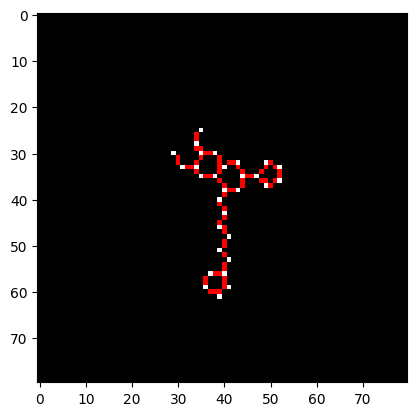

In [19]:
mol = data["mol"][random.randint(0, data.shape[0])]
v = chemcepterize_mol(mol)

print(v.shape)
plt.imshow(v[:,:,:3])

In [20]:
data_image = data[['CELL_LINE_NAME', 'molimage', 'MIN_CONC', 'MAX_CONC', 'LN_IC50']]
print(data_image.shape)

data_image.loc[:, 'MIN_CONC'] = np.log(data_image['MIN_CONC'])
data_image.loc[:, 'MAX_CONC'] = np.log(data_image['MAX_CONC'])
data_image.sample(10)

(218139, 5)


,CELL_LINE_NAME,molimage,MIN_CONC,MAX_CONC,LN_IC50
172694,FU-OV-1,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...",-4.604670,2.302585,2.480072
156399,COLO-680N,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...",-4.604670,2.302585,5.895208
201396,LNZTA3WT4,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...",-4.604670,2.302585,2.341307
205211,NCI-H2795,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...",-6.906756,0.000000,3.180895
3392,SK-GT-2,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...",-11.250561,-4.382027,-6.090602
211292,SKN-3,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...",-4.604670,2.302585,2.580540
78197,NCI-H250,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...",-5.297718,2.302585,6.064096
199756,NCI-H2342,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...",-4.604670,2.302585,4.955571
50731,YT,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...",-11.512925,-4.605170,-2.182671
208692,LU-165,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...",-4.604670,2.302585,6.394163


In [21]:
# Load and prepare dataset
images = np.array(list(data_image['molimage']))
features_scaled = data_image[['MIN_CONC', 'MAX_CONC']].values
target = data_image['LN_IC50'].values

# One-hot encoding CELL_LINE_NAME
encoder = OneHotEncoder(sparse_output=False)
cell_lines_encoded = encoder.fit_transform(data_image[['CELL_LINE_NAME']])

In [22]:
# Image augmentation setup
augmentations = ImageDataGenerator(
    rotation_range = 180,           # Randomly rotates the image up to 180 degrees.
    width_shift_range = 0.1,        # Randomly shifts the image horizontally by up to 10% of the total width.
    height_shift_range = 0.1,       # Randomly shifts the image vertically by up to 10% of the total height.
    fill_mode = "constant",         # Determines how newly created pixels are filled after rotation/shift. In this case, it uses a constant value.
    cval = 0,                       # When 'fill_mode' is set to 'constant', this value is used to fill in empty pixels created by rotation/shift (0 = black).
    horizontal_flip = True,         # Randomly flips the image horizontally.
    vertical_flip = True)           # Randomly flips the image vertically.

In [23]:
# Split data into training and test sets (90% train, 10% test)
train_val_indices, test_indices = train_test_split(np.arange(features_scaled.shape[0]), test_size=0.1, random_state=42)

# Now split the training set into training and validation sets (80% of the 90% for train, 20% of 90% for val)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.2, random_state=42)  # 72%, 18%, 10%

# Create generators for training and validation
train_images = images[train_indices]
train_features = np.hstack((features_scaled[train_indices], cell_lines_encoded[train_indices]))
train_labels = target[train_indices].reshape(-1, 1)
train_generator = DataGenerator(train_images, train_features, train_labels, BATCH_SIZE, augmentations)

val_images = images[val_indices]
val_features = np.hstack((features_scaled[val_indices], cell_lines_encoded[val_indices]))
val_labels = target[val_indices].reshape(-1, 1)
val_generator = DataGenerator(val_images, val_features, val_labels, BATCH_SIZE)

test_images = images[test_indices]
test_features = np.hstack((features_scaled[test_indices], cell_lines_encoded[test_indices]))
test_labels = target[test_indices].reshape(-1, 1)
test_generator = DataGenerator(test_images, test_features, test_labels, BATCH_SIZE)

In [24]:
# Model definition
input_img = Input(shape=images.shape[1:])
input_features = Input(shape=(features_scaled.shape[1] + cell_lines_encoded.shape[1],))
x = Inception0(input_img)
x = Inception(x)
x = Inception(x)

od = int(x.shape[1])
x = MaxPooling2D(pool_size=(od, od), strides=(1, 1))(x)
x = Flatten()(x)
concat = Concatenate()([x, input_features])
x = Dense(100, activation='relu')(concat)
output = Dense(1, activation='linear')(x)

# Create and compile the model
model = Model(inputs=[input_img, input_features], outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 4)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 16)           80        ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 80, 80, 16)           80        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 80, 80, 16)           2320      ['conv2d[0][0]']              
                                                                                              

In [25]:
optimizer = Adam(learning_rate = 0.00025)
lr_metric = get_lr_metric(optimizer)
# model.compile(loss="mse", optimizer=optimizer, metrics=['mae', 'mse'])
model.compile(loss="mse", optimizer=optimizer, metrics=[coeff_determination, lr_metric])
# model.compile(loss="mse", optimizer=optimizer)

# Training with callbacks
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=MIN_LEARNING_RATE, verbose=1, mode = 'auto', cooldown = 0),
    ModelCheckpoint(filepath="weights.best.keras", monitor='val_loss', save_best_only=True, verbose=1, mode = 'auto'),
    EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True)]

In [26]:
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(157060, 1)
(39265, 1)
(21814, 1)


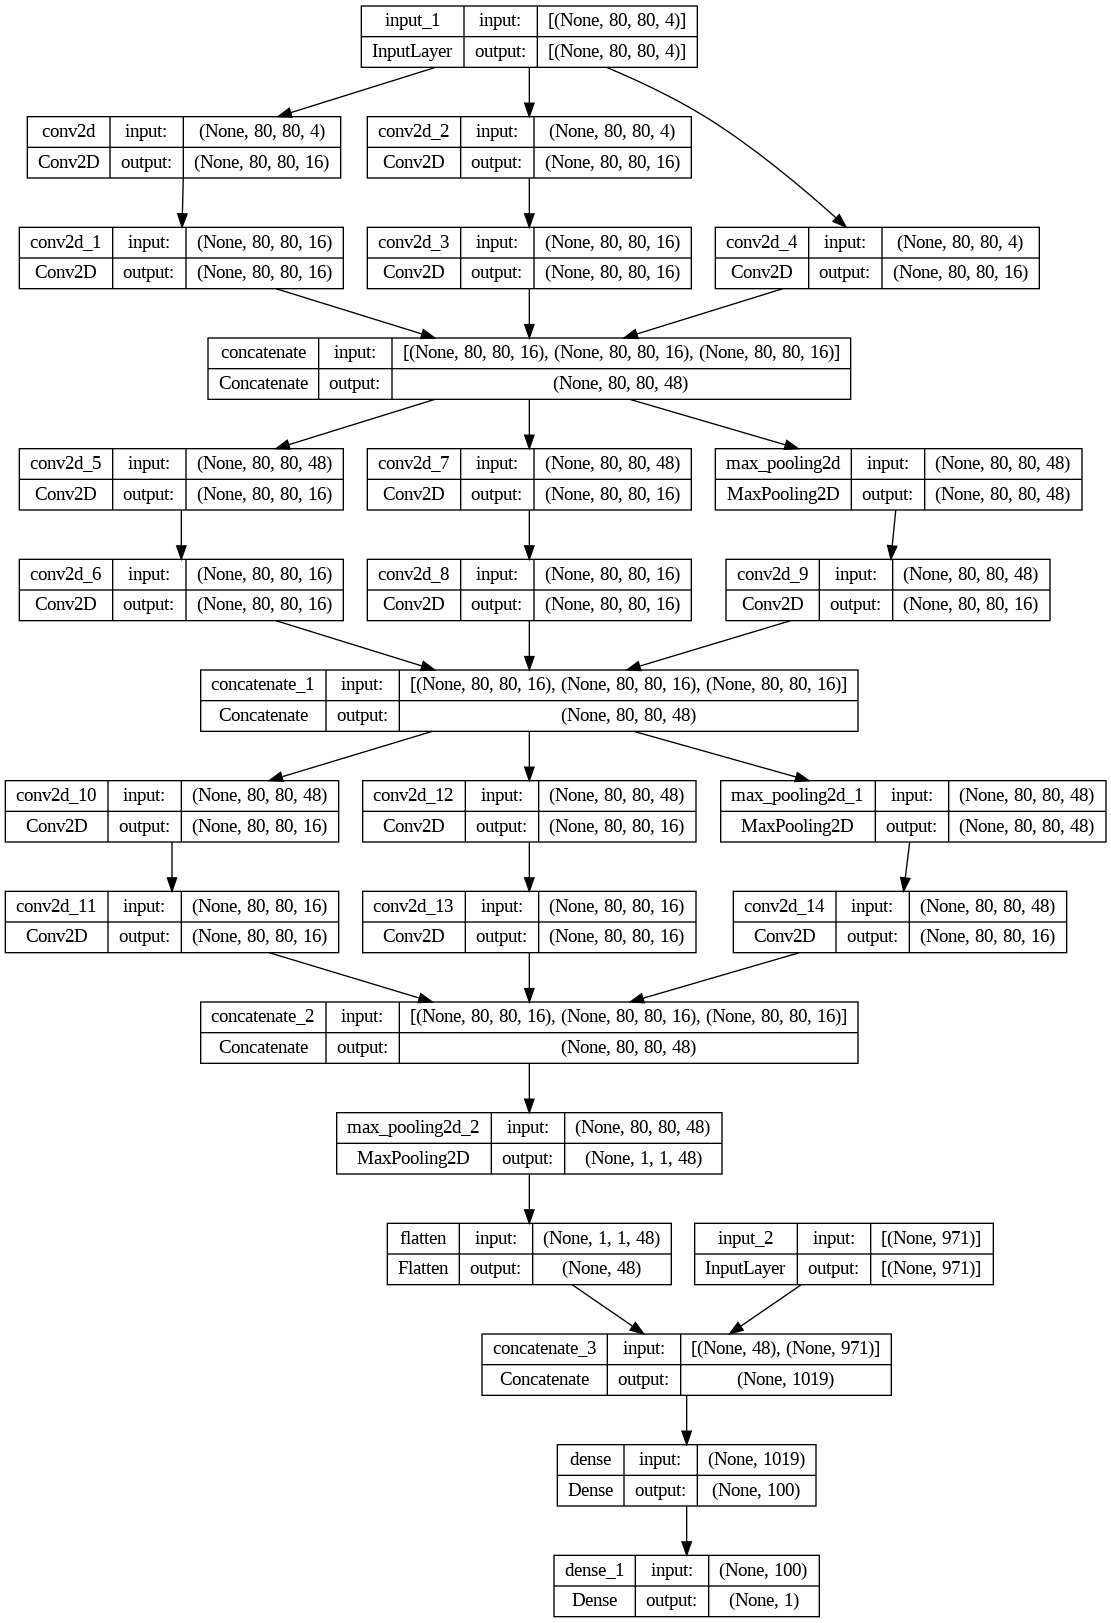

In [27]:
# Generate a plot of the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Model training with explicit validation data
history = model.fit(
    train_generator,
    steps_per_epoch = int(10000/BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_list
)

Epoch 1/300
78/78 [==============================] - ETA: 0s - loss: 9.0352 - coeff_determination: -0.1887 - lr: 2.5000e-04
Epoch 1: val_loss improved from inf to 7.86454, saving model to weights.best.keras
78/78 [==============================] - 189s 2s/step - loss: 9.0352 - coeff_determination: -0.1887 - lr: 2.5000e-04 - val_loss: 7.8645 - val_coeff_determination: -0.0075 - val_lr: 2.5000e-04
Epoch 2/300
78/78 [==============================] - ETA: 0s - loss: 6.1596 - coeff_determination: 0.2048 - lr: 2.5000e-04
Epoch 2: val_loss improved from 7.86454 to 6.14482, saving model to weights.best.keras
78/78 [==============================] - 184s 2s/step - loss: 6.1596 - coeff_determination: 0.2048 - lr: 2.5000e-04 - val_loss: 6.1448 - val_coeff_determination: 0.2124 - val_lr: 2.5000e-04
Epoch 3/300
78/78 [==============================] - ETA: 0s - loss: 5.0673 - coeff_determination: 0.3420 - lr: 2.5000e-04
Epoch 3: val_loss improved from 6.14482 to 5.03670, saving model to weights.be

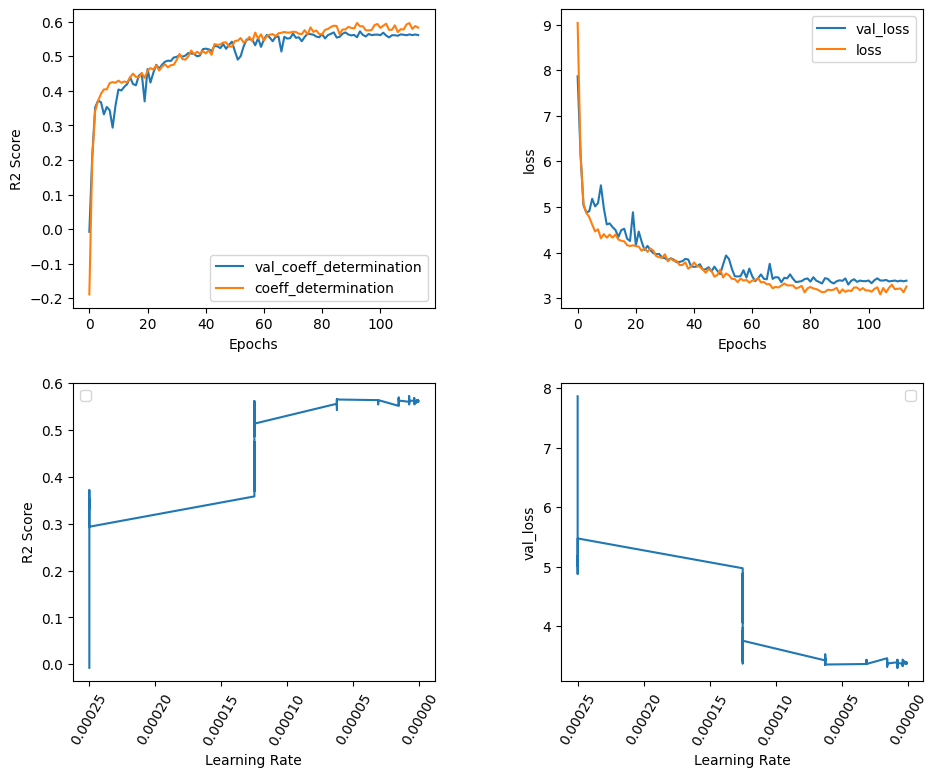

In [ ]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination', 'coeff_determination']:
    plt.subplot(221)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("R2 Score")

for label in ['val_loss', 'loss']:
    plt.subplot(222)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")


plt.subplot(223)
plt.plot(hist['lr'], hist['val_coeff_determination'])
plt.legend()
plt.xlabel("Learning Rate")
plt.xticks(rotation=60)
plt.ylabel("R2 Score")
plt.gca().invert_xaxis()

plt.subplot(224)
plt.plot( hist['lr'], hist['val_loss'])
plt.legend()
plt.xlabel("Learning Rate")
plt.xticks(rotation=60)
plt.ylabel("val_loss")
plt.gca().invert_xaxis()

plt.subplots_adjust(
    top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

plt.savefig('plot.png', dpi=300, bbox_inches='tight')

In [29]:
# Load the best model
model.load_weights("weights.best.keras")

# Predict on the validation set
predictions = model.predict(test_generator)

171/171 [==============================] - 47s 272ms/step


In [30]:
# Calculate evaluation metrics
rmse = math.sqrt(mean_squared_error(test_labels, predictions))
mae = mean_absolute_error(test_labels, predictions)
mape = mean_absolute_percentage_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)
# msle = mean_squared_log_error(np.exp(test_labels), np.exp(predictions))

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
# print(f"MSLE: {msle}")
print(f"R-squared: {r2}")

print()
print(f"True Values-      Min: {np.min(val_labels)}, Mean :{np.mean(val_labels)}, Max :{np.max(val_labels)}")
print(f"Predicted Values- Min: {np.min(predictions)}, Mean :{np.mean(predictions)}, Max :{np.max(predictions)}")

RMSE: 1.8092177010166428
MAE: 1.4288918810989126
MAPE: 2.2654542233096433%
R-squared: 0.5779928935343187

True Values-      Min: -8.554725, Mean :2.7544779895326625, Max :13.26373
Predicted Values- Min: -7.449532508850098, Mean :2.9812803268432617, Max :12.157515525817871


In [31]:
t_statistic, p_value = stats.ttest_rel(test_labels, predictions)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level

if p_value < alpha:
    print("The difference between true and predicted values is statistically significant.")
else:
    print("The difference between true and predicted values is not statistically significant.")

T-statistic: [-18.65634907]
P-value: [4.4651512e-77]
The difference between true and predicted values is statistically significant.


### Interpretation of the Significance

Your paired t-test has provided the following results:

- **T-statistic:** -18.6563
- **P-value:** 4.47e-77
- **Alpha (significance level):** 0.05

#### Key Points:

1. **P-value = 4.47e-77:**
   - The p-value is extremely small, much smaller than your significance level of 0.05. This means the probability of observing the difference between the true and predicted values by chance is extremely low.
   - Since the p-value is far below 0.05, you **reject the null hypothesis**, concluding that there is a **statistically significant difference** between your model’s predictions and the true values.

2. **T-statistic = -18.6563:**
   - The negative t-statistic suggests that, on average, the predicted values are consistently **lower** than the true values. The magnitude of the t-statistic is large, further indicating that the difference between the predicted and true values is substantial.
   - A large absolute t-statistic value (far from 0) suggests that the difference between the two sets of values is unlikely to be due to random noise.

### Conclusion:
- **Result:** The difference between the true values and the model's predictions is **statistically significant**.
- **Implication:** This result implies that your model's predictions deviate substantially from the true values, in a way that is not due to random variation. However, the significant difference in this case is likely **unfavorable**—the negative t-statistic indicates that the model is underestimating the true values.